<a href="https://colab.research.google.com/github/Ashail33/Masters-work/blob/master/Call_all_functions_and_run_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("my-app-name").master("local[*]").getOrCreate()



from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from sklearn.base import BaseEstimator, ClusterMixin
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans as PKMeans
from sklearn.cluster import KMeans as SKKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

from collections import defaultdict
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import cdist
import time
import psutil
import os
import tracemalloc
from google.colab import drive
import glob
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
import json

from sklearn.neighbors import KDTree
import numpy as np
from sklearn.metrics import pairwise_distances

In [2]:
from sklearn import metrics

#evaluation code
class Timer:
    def __enter__(self):
        self.start_time = time.monotonic()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.interval = time.monotonic() - self.start_time


class MemoryMonitor:
    def __enter__(self):
        self.process = psutil.Process(os.getpid())
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.memory_info = self.process.memory_info()


class DiskMonitor:
    def __enter__(self):
        self.disk_read_start = psutil.disk_io_counters().read_bytes
        self.disk_write_start = psutil.disk_io_counters().write_bytes
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.disk_read_end = psutil.disk_io_counters().read_bytes
        self.disk_write_end = psutil.disk_io_counters().write_bytes
        self.disk_read_bytes = self.disk_read_end - self.disk_read_start
        self.disk_write_bytes = self.disk_write_end - self.disk_write_start


def compactness(X, labels):
    labels = labels.flatten()
    unique_labels = np.unique(labels)
    centroids = np.array([np.mean(X[labels == i], axis=0) for i in unique_labels])
    distances = cdist(X, centroids)
    return np.sum(np.min(distances, axis=1))


def separation(X, labels):
    labels = labels.flatten()
    unique_labels = np.unique(labels)
    centroids = np.array([np.mean(X[labels == i], axis=0) for i in unique_labels])
    return np.sum(cdist(centroids, centroids))



def batched_silhouette_score(X, labels, batch_size=100000):
    labels = labels.flatten()
    n_samples = len(X)
    n_batches = int(np.ceil(n_samples / batch_size))

    silhouette_sum = 0

    for i in range(n_batches):
        start = i * batch_size
        end = min(start + batch_size, n_samples)

        pairwise_distances = metrics.pairwise_distances(X[start:end], X)

        a = np.array([np.mean(pairwise_distances[i, labels == labels[start + i]]) for i in range(end-start)])
        b = np.array([np.min([np.mean(pairwise_distances[i, labels == cur_label]) 
                              for cur_label in set(labels) - {labels[start + i]}]) 
                      for i in range(end-start)])

        silhouette_sum += np.sum((b - a) / np.maximum(a, b))

    return silhouette_sum / n_samples

def dunn_index(X, labels):
    labels = labels.flatten()
    unique_labels = np.unique(labels)
    clusters = [X[labels == i] for i in unique_labels]
    max_intra_cluster_distance = np.max([np.max(cdist(c1, c1)) for c1 in clusters])

    min_inter_cluster_distance = np.inf
    for i, c1 in enumerate(clusters):
        for j, c2 in enumerate(clusters):
            if i < j:
                min_distance = np.min(cdist(c1, c2))
                if min_distance < min_inter_cluster_distance:
                    min_inter_cluster_distance = min_distance

    return min_inter_cluster_distance / max_intra_cluster_distance

from scipy.spatial.distance import pdist, cdist

def batched_dunn_index(X, labels, batch_size=100000):
    n_samples = len(X)
    n_batches = int(np.ceil(n_samples / batch_size))

    max_intra_cluster_distance = -np.inf
    min_inter_cluster_distance = np.inf

    for i in range(n_batches):
        start = i * batch_size
        end = min(start + batch_size, n_samples)

        batch = X[start:end]
        batch_labels = labels[start:end]

        unique_labels = np.unique(batch_labels)

        for label in unique_labels:
            cluster = batch[batch_labels == label]
            intra_cluster_distance = np.max(pdist(cluster))

            if intra_cluster_distance > max_intra_cluster_distance:
                max_intra_cluster_distance = intra_cluster_distance

        for i, c1 in enumerate(unique_labels):
            for j, c2 in enumerate(unique_labels):
                if i < j:
                    inter_cluster_distance = np.min(cdist(X[labels == c1], X[labels == c2]))

                    if inter_cluster_distance < min_inter_cluster_distance:
                        min_inter_cluster_distance = inter_cluster_distance

    return min_inter_cluster_distance / max_intra_cluster_distance


# code to evaluate the clustering algorithms
def evaluate_clustering(algorithm, dataset, true_labels=None, n_runs=5):
    results = defaultdict(list)

    metric_function_map = {
        'cp': compactness,
        'sp': separation,
        'db': davies_bouldin_score,
        'silhouette': silhouette_score,
        'calinski_harabasz': calinski_harabasz_score,
        'ari': adjusted_rand_score,
        'nmi': normalized_mutual_info_score,
        'dvi': dunn_index,
    }

    previous_runs_labels = []
    previous_runs_results = []

    # Start memory monitoring before the loop
    tracemalloc.start()

    for _ in range(n_runs):
        with Timer() as t, DiskMonitor() as d:
            labels = algorithm.fit_predict(dataset)

        # Memory usage tracking
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        results['memory_usage'].append(current_memory)
        results['memory_peak'].append(peak_memory)

        results['runtime'].append(t.interval)
        results['disk_read'].append(d.disk_read_bytes)
        results['disk_write'].append(d.disk_write_bytes)

        if true_labels is not None:
            previous_runs_labels.append(labels)

            metric_results = {}

            # Calculate clustering performance metrics
            for metric_name, metric_function in metric_function_map.items():
                try:
                    value = metric_function(dataset, labels) if metric_name in {'calinski_harabasz', 'davies_bouldin_score', 'silhouette_score', 'cp', 'sp', 'dvi'} else metric_function(true_labels.flatten(), labels.flatten()) if metric_name in {'ari', 'nmi'} else metric_function(dataset, labels.reshape(-1, 1))
                    metric_results[metric_name] = value
                except ValueError as e:
                    print(f"Error calculating {metric_name}: {e}")
                    metric_results[metric_name] = np.nan

            # Add the current run's results to the list of previous runs
            previous_runs_results.append(metric_results)

    # Stop memory monitoring after the loop
    tracemalloc.stop()

    # Aggregate the results over all runs
    for metric_name in metric_function_map.keys():
        metric_values = [run_result[metric_name] for run_result in previous_runs_results]
        results[f"{metric_name}_mean"].append(np.mean(metric_values))
        results[f"{metric_name}_std"].append(np.std(metric_values))
        results[f"{metric_name}_max"].append(np.max(metric_values))
        results[f"{metric_name}_min"].append(np.min(metric_values))

    # Calculate min, max, mean, and std of memory usage over all runs
    memory_usages = np.array(results['memory_usage'])
    memory_stats = {
        'memory_min': np.min(memory_usages),
        'memory_max': np.max(memory_usages),
        'memory_mean': np.mean(memory_usages),
        'memory_std': np.std(memory_usages)
    }

    # Save memory stats
    for stat_name, stat_value in memory_stats.items():
        results[stat_name].append(stat_value)
    results['runtime_mean'] = np.mean(results['runtime'])
    results['runtime_std'] = np.std(results['runtime'])
    results['runtime_max'] = np.max(results['runtime'])
    results['runtime_min'] = np.min(results['runtime'])

    return dict(results)

In [3]:
#use this function for weighted consensus method, it has it's issues like the fit to complex shapes irrespective of the underlying model, the spectral clustering of the affinity matrix makes this tricky. This is definitely a shortfall of the method


from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering, KMeans
import numpy as np

class ConsensusClustering:
    def __init__(self, n_clusters, model_funcs, weights=None, sampling_rate=0.8, random_state=None):
        self.n_clusters = n_clusters
        self.model_funcs = model_funcs
        self.weights = weights
        self.sampling_rate = sampling_rate
        self.random_state = random_state
        self.co_association_matrix = None

    def fit_predict(self, data):
        n_samples = data.shape[0]
        n_models = len(self.model_funcs)

        if self.weights is None:
            self.weights = np.ones(n_models)

        if len(self.weights) != n_models:
            raise ValueError("The number of weights must be equal to the number of models.")

        self.weights = self.weights / np.sum(self.weights)

        self.co_association_matrix = np.zeros((n_samples, n_samples))

        for i in range(n_models):
            model_func = self.model_funcs[i]
            model = model_func(self.n_clusters)
            sampled_indices = np.random.choice(n_samples, int(n_samples * self.sampling_rate), replace=True)
            sampled_data = data[sampled_indices]
            
            if callable(model):
                labels = model(sampled_data)
            else:
                labels = model.fit_predict(sampled_data)

            for label in range(self.n_clusters):
                cluster_indices = np.where(labels == label)[0]
                original_indices = sampled_indices[cluster_indices]
                pairs = itertools.combinations(original_indices, 2)
                for x, y in pairs:
                    self.co_association_matrix[x, y] += self.weights[i]
                    self.co_association_matrix[y, x] += self.weights[i]

        spectral_clustering = SpectralClustering(n_clusters=self.n_clusters, affinity='precomputed')
        final_labels = spectral_clustering.fit_predict(self.co_association_matrix)

        return final_labels


# Model functions for k-means and Agglomerative clustering
def kmeans_model_func(n_clusters, random_state):
    return KMeans(n_clusters=n_clusters, random_state=random_state)

def agglomerative_model_func(n_clusters, random_state):
    return AgglomerativeClustering(n_clusters=n_clusters)

def dbscan_model_func(n_clusters):
    return DBSCAN(eps=0.15, min_samples=10)

def optics_model_func(n_clusters, random_state):
    return OPTICS(min_samples=1, xi=0.5, cluster_method='xi', n_jobs=-1)

def optics_DB_Scan_model_func(n_clusters, random_state):
    def optics_instance(data):
        optics = OPTICS(min_samples=1, n_jobs=-1)
        optics.fit(data)
        eps = np.partition(optics.reachability_[optics.ordering_], n_clusters - 1)[n_clusters - 1]
        labels = cluster_optics_dbscan(reachability=optics.reachability_,
                                       core_distances=optics.core_distances_,
                                       ordering=optics.ordering_,
                                       eps=eps)
        return labels

    return optics_instance   

# Define your models in a list
model_funcs = [KMeans]*5

# Define the weights for the models
weights = [0.5, 0.2,0.003,0.4,3]

# # Initialize ConsensusClustering
# consensus_clustering = ConsensusClustering(n_clusters=2, model_funcs=model_funcs, weights=weights, sampling_rate=0.8)

# # Load your data
# data, _ = make_moons(n_samples=200, noise=0.05, random_state=0)

# # Apply consensus clustering
# labels = consensus_clustering.fit_predict(data)

# # `labels` now contains the cluster assignments for each sample in `data`.
# import matplotlib.pyplot as plt

# # Plot the data points with colors corresponding to the assigned cluster
# plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6)

# # Title and axis labels
# plt.title('Consensus Clustering Results')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')

# # Show the plot
# plt.show()


In [4]:
import numpy as np
from sklearn.datasets import load_iris, load_digits, make_blobs
from sklearn.cluster import KMeans as SKKMeans
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import timeit
from pyspark.ml.evaluation import ClusteringEvaluator
# Set up SparkSession
spark = SparkSession.builder.appName("MapReduceKMeans").getOrCreate()
sc = spark.sparkContext

from pyspark.ml.clustering import KMeans as PKMeans

# def mapreduce_kmeans(data, n_clusters, batch_size, max_iterations):
#     """
#     MapReduce KMeans implementation using PySpark.
#     """
#     spark = SparkSession.builder.getOrCreate()
#     sc = spark.sparkContext
#     sc.setLogLevel("ERROR")
#     # Convert numpy array to PySpark DataFrame
#     df = sc.parallelize(data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
#     # Initialize centroids using KMeans++ initialization
#     initial_centroids = PKMeans().fit(df.select("features")).clusterCenters()
#     global_centroids = initial_centroids
#     for i in range(0, data.shape[0], batch_size):
#         # Split data into batches
#         local_data = data[i:i+batch_size]
#         local_df = sc.parallelize(local_data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
#         # Train local KMeans model
#         local_kmeans = PKMeans(k=n_clusters, initMode="k-means||", maxIter=max_iterations, seed=42)
#         local_model = local_kmeans.fit(local_df.select("features"))
#         local_centroids = local_model.clusterCenters()
#         # Update global centroids
#         global_centroids = np.vstack([global_centroids, local_centroids])
#         global_centroids = SKKMeans(n_clusters=n_clusters, random_state=42).fit(global_centroids).cluster_centers_
#     # Final KMeans model with global centroids
#     kmeans = PKMeans(k=n_clusters, initMode="k-means||", maxIter=max_iterations, seed=42)
#     final_model = kmeans.fit(df.select("features"))
#     evaluator = ClusteringEvaluator()
#     global_cost = evaluator.evaluate(final_model.transform(df))
#     global_centroids = final_model.clusterCenters()
#     return KMeans(n_clusters=n_clusters, init=global_centroids, n_init=1, random_state=42)
# # MapReduce KMeans
# time_mbkmeans = []
# inertia_mbkmeans = []
# # Load datasets
# iris_data = load_iris().data
# digits_data = load_digits().data
# blobs_data = make_blobs(n_samples=10000, centers=3, n_features=2, random_state=42)[0]

# # Define parameters for KMeans and MapReduce KMeans
# n_clusters = 3
# batch_size = 1000
# max_iterations = 100

# for data in [iris_data, digits_data, blobs_data]:
#     mbkmeans= mapreduce_kmeans(data, n_clusters, batch_size, max_iterations)
#     # mbkmeans = KMeans(n_clusters=n_clusters, init=global_centroids, n_init=1, random_state=42)
#     time_taken = %timeit -o -r 1 -n 1 mbkmeans.fit(data)
#     time_mbkmeans.append(time_taken.best)
#     inertia_mbkmeans.append(mbkmeans.inertia_)












# from sklearn.cluster import KMeans



# # Regular KMeans
# time_kmeans = []
# inertia_kmeans = []
# for data in [iris_data, digits_data, blobs_data]:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     result = %timeit -o -r 1 -n 1 kmeans.fit(data)
#     time_kmeans.append(result.best)
#     inertia_kmeans.append(kmeans.inertia_)
# # Visualize results
# datasets = ["Iris", "Digits", "Blobs"]
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# ax1.bar(datasets, time_kmeans, label="KMeans")
# ax1.bar(datasets, time_mbkmeans, bottom=time_kmeans, label="MapReduceKMeans")
# ax1.set_title("Runtime Comparison")
# ax1.set_ylabel("Time (s)")
# ax1.legend()

# ax2.bar(datasets, inertia_kmeans, label="KMeans")
# ax2.bar(datasets, inertia_mbkmeans, bottom=inertia_kmeans, label="MapReduceKMeans")
# ax2.set_title("Inertia Comparison")
# ax2.set_ylabel("Inertia")
# ax2.legend()

# plt.tight_layout()
# plt.show()


In [5]:
from pyspark.ml.clustering import KMeans as PKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.cluster import KMeans as SKKMeans
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
import numpy as np
from sklearn.cluster import KMeans

import numpy as np
from sklearn.datasets import load_iris, load_digits, make_blobs
from sklearn.cluster import KMeans as SKKMeans
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import timeit
from pyspark.ml.evaluation import ClusteringEvaluator
# Set up SparkSession
spark = SparkSession.builder.appName("MapReduceKMeans").getOrCreate()
sc = spark.sparkContext

from pyspark.ml.clustering import KMeans as PKMeans

class MapReduceKMeans:
    def __init__(self, n_clusters, batch_size, max_iterations):
        self.n_clusters = n_clusters
        self.batch_size = batch_size
        self.max_iterations = max_iterations

    def fit_predict(self, data):
        """
        MapReduce KMeans implementation using PySpark.
        """
        spark = SparkSession.builder.getOrCreate()
        sc = spark.sparkContext
        sc.setLogLevel("ERROR")
        # Convert numpy array to PySpark DataFrame
        df = sc.parallelize(data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
        # Initialize centroids using KMeans++ initialization
        initial_centroids = PKMeans().fit(df.select("features")).clusterCenters()
        global_centroids = initial_centroids
        for i in range(0, data.shape[0], self.batch_size):
            # Split data into batches
            local_data = data[i:i+self.batch_size]
            local_df = sc.parallelize(local_data.tolist()).map(lambda x: (Vectors.dense(x), )).toDF(["features"])
            # Train local KMeans model
            local_kmeans = PKMeans(k=self.n_clusters, initMode="k-means||", maxIter=self.max_iterations, seed=42)
            local_model = local_kmeans.fit(local_df.select("features"))
            local_centroids = local_model.clusterCenters()
            # Update global centroids
            global_centroids = np.vstack([global_centroids, local_centroids])
            global_centroids = SKKMeans(n_clusters=self.n_clusters, random_state=42).fit(global_centroids).cluster_centers_
        # Final KMeans model with global centroids
        kmeans = PKMeans(k=self.n_clusters, initMode="k-means||", maxIter=self.max_iterations, seed=42)
        final_model = kmeans.fit(df.select("features"))
        evaluator = ClusteringEvaluator()
        global_cost = evaluator.evaluate(final_model.transform(df))
        global_centroids = final_model.clusterCenters()
        return KMeans(n_clusters=self.n_clusters, init=global_centroids, n_init=1, random_state=42).fit_predict(data)


# # MapReduce KMeans
# time_mbkmeans = []
# inertia_mbkmeans = []
# # Load datasets
# iris_data = load_iris().data
# digits_data = load_digits().data
# blobs_data = make_blobs(n_samples=10000, centers=3, n_features=2, random_state=42)[0]

# # Define parameters for KMeans and MapReduce KMeans
# n_clusters = 3
# batch_size = 1000
# max_iterations = 100

# for data in [iris_data, digits_data, blobs_data]:
#     mbkmeans= mapreduce_kmeans(data, n_clusters, batch_size, max_iterations)
#     # mbkmeans = KMeans(n_clusters=n_clusters, init=global_centroids, n_init=1, random_state=42)
#     time_taken = %timeit -o -r 1 -n 1 mbkmeans.fit(data)
#     time_mbkmeans.append(time_taken.best)
#     inertia_mbkmeans.append(mbkmeans.inertia_)

# from sklearn.cluster import KMeans



# # Regular KMeans
# time_kmeans = []
# inertia_kmeans = []
# for data in [iris_data, digits_data, blobs_data]:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     result = %timeit -o -r 1 -n 1 kmeans.fit(data)
#     time_kmeans.append(result.best)
#     inertia_kmeans.append(kmeans.inertia_)
# # Visualize results
# datasets = ["Iris", "Digits", "Blobs"]
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# ax1.bar(datasets, time_kmeans, label="KMeans")
# ax1.bar(datasets, time_mbkmeans, bottom=time_kmeans, label="MapReduceKMeans")
# ax1.set_title("Runtime Comparison")
# ax1.set_ylabel("Time (s)")
# ax1.legend()

# ax2.bar(datasets, inertia_kmeans, label="KMeans")
# ax2.bar(datasets, inertia_mbkmeans, bottom=inertia_kmeans, label="MapReduceKMeans")
# ax2.set_title("Inertia Comparison")
# ax2.set_ylabel("Inertia")
# ax2.legend()

# plt.tight_layout()
# plt.show()


In [6]:
# # Usage:
# from sklearn.datasets import make_moons

# # Load the moons dataset
# moons_data, moons_labels = make_moons(n_samples=500, noise=0.001, random_state=42)

# # Apply SSClustering
# ss_clustering = mapreduce_kmeans(data, 2, batch_size, max_iterations)
# cluster_assignments = ss_clustering.fit_predict(moons_data)


# # Plot the results
# plt.scatter(moons_data[:, 0], moons_data[:, 1], c=cluster_assignments, cmap='viridis')
# plt.show()

In [7]:
from sklearn.cluster import MiniBatchKMeans
# from sklearn.datasets import make_blobs

# # Generate some random data
# X, y = make_blobs(n_samples=100000, centers=10, n_features=100, random_state=42)

# # Create and fit the MiniBatchKMeans model
# batch_size = 1000
# n_clusters = 10
# mbkmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42)
# mbkmeans.fit(X)

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.linear_model import ElasticNet
import scipy.sparse.linalg as sp_linalg
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from scipy.sparse import lil_matrix

class SSClustering(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=2, alpha=0.09, l1_ratio=0.2, k=10):
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.k = k

    @staticmethod
    def normalize_columns(X):
        norms = np.linalg.norm(X, axis=0)
        return X / norms[np.newaxis, :]

    # def compute_sparse_representation(self, X):
    #     n_samples = X.shape[1]
    #     A = np.zeros((n_samples, n_samples))
        
    #     for i in range(n_samples):
    #         x_i = X[:, i]
    #         X_rest = np.delete(X, i, axis=1)
    #         elastic_net = ElasticNet(alpha=self.alpha, l1_ratio=self.l1_ratio, fit_intercept=False)
    #         elastic_net.fit(X_rest, x_i)
    #         coeffs = elastic_net.coef_
    #         A[np.arange(n_samples) != i, i] = coeffs

    #     return A

    def compute_sparse_representation(self, X):
        n_samples = X.shape[1]
        A = lil_matrix((n_samples, n_samples))
        
        def fit_model(i):
            x_i = X[:, i]
            X_rest = np.delete(X, i, axis=1)
            elastic_net = ElasticNet(alpha=self.alpha, l1_ratio=self.l1_ratio, fit_intercept=False)
            elastic_net.fit(X_rest, x_i)
            coeffs = elastic_net.coef_
            return coeffs

        # Use Joblib to parallelize the loop
        results = Parallel(n_jobs=-1)(delayed(fit_model)(i) for i in range(n_samples))

        for i in range(n_samples):
            A[np.arange(n_samples) != i, i] = results[i]

        return A

    def spectral_clustering(self, A):
        Laplacian = np.diag(np.sum(np.abs(A), axis=0)) - A
        eigvals, eigvecs = np.linalg.eig(Laplacian)
        idx = eigvals.argsort()[:self.n_clusters]
        U = np.real(eigvecs[:, idx])

        kmeans = KMeans(n_clusters=self.n_clusters, random_state=0)
        return kmeans.fit_predict(U)

    def fit_predict(self, X, y=None):
        X = self.normalize_columns(X.T)
        A = self.compute_sparse_representation(X)
        A = np.abs(A) + np.abs(A.T)

        if self.k is not None:
            for i in range(A.shape[0]):
                idx = np.argsort(A[i, :])[:-self.k - 1:-1]
                A[i, np.setdiff1d(np.arange(A.shape[1]), idx)] = 0

        return self.spectral_clustering(A)


# # Usage:
from sklearn.datasets import make_moons

# Load the moons dataset
moons_data, moons_labels = make_moons(n_samples=5000, noise=0.001, random_state=42)

# Apply SSClustering
ss_clustering = SSClustering(n_clusters=2, alpha=0.8, l1_ratio=0.5, k=20000)
cluster_assignments = ss_clustering.fit_predict(moons_data)


# Plot the results
plt.scatter(moons_data[:, 0], moons_data[:, 1], c=cluster_assignments, cmap='viridis')
plt.show()


In [48]:
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.linear_model import ElasticNet
import scipy.sparse.linalg as sp_linalg
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from scipy.sparse import lil_matrix

import numpy as np
from sklearn.linear_model import Lasso
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh

class S5C:
    def __init__(self, n_clusters, alpha=1.0, l1_ratio=1.0, k=None, T=100, B=50):
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.k = k
        self.T = T
        self.B = B

    def normalize_columns(self, X):
        norms = np.linalg.norm(X, axis=0)
        return X / norms[None, :]

    def compute_sparse_representation(self, X):
        N = X.shape[0]
        C = np.zeros((N, N))
        for i in range(N):
            model = ElasticNet(alpha=self.alpha, l1_ratio=self.l1_ratio)
            model.fit(X[np.arange(N) != i], X[i])
            C[i, np.arange(N) != i] = model.coef_
        return C

    def spectral_clustering(self, A):
        Laplacian = np.diag(np.sum(np.abs(A), axis=0)) - A
        eigvals, eigvecs = eigsh(Laplacian, k=self.n_clusters, which='SM')
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=0)
        return kmeans.fit_predict(eigvecs)

    def fit_predict(self, X, y=None):
        X = self.normalize_columns(X.T)
        S = set()
        N = X.shape[1]

        for t in range(self.T):
            I = np.random.choice(N, self.B, replace=False)
            C_I = self.compute_sparse_representation(X[:, I])
            g = np.zeros(N)
            for i_prime in I:
                g[i_prime] = np.linalg.norm(X[:, i_prime] - X @ C_I[:, i_prime])**2
            i_plus = np.argmax(g)
            if g[i_plus] > 0:
                S.add(i_plus)

        A = self.compute_sparse_representation(X[:, list(S)])
        A = np.abs(A) + np.abs(A.T)

        if self.k is not None:
            for i in range(A.shape[0]):
                idx = np.argsort(A[i, :])[:-self.k - 1:-1]
                A[i, np.setdiff1d(np.arange(A.shape[1]), idx)] = 0

        return self.spectral_clustering(A)



import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Load the moons dataset
moons_data, moons_labels = make_moons(n_samples=500, noise=0.001, random_state=42)

# Apply S5CClustering
s5c_clustering = S5C(n_clusters=4, alpha=1.0, l1_ratio=1.0, k=None, T=100, B=50)

cluster_assignments = s5c_clustering.fit_predict(moons_data)

# Plot the results
plt.scatter(moons_data[:, 0], moons_data[:, 1], c=cluster_assignments, cmap='viridis')
plt.show()


ValueError: ignored

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested

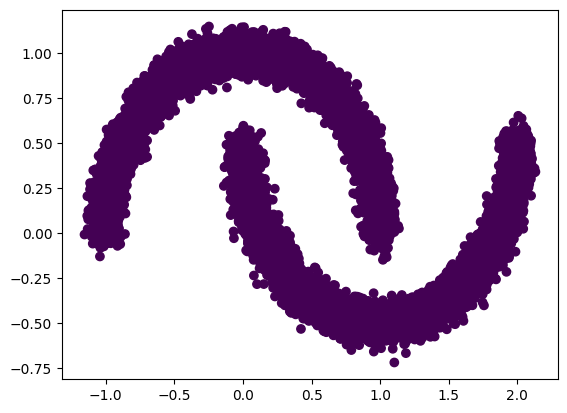

In [82]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

class S5C:
    def __init__(self, n_clusters=2, n_nonzero_coefs=10, T=10, B=10):
        self.n_clusters = n_clusters
        self.n_nonzero_coefs = n_nonzero_coefs
        self.T = T
        self.B = B

    def compute_sparse_representation(self, X):
        N = X.shape[0]
        C = np.zeros((N, N))
        for i in range(N):
            # Select all other points
            X_subset = X[np.arange(N) != i]
            # Fit OMP model
            model = OrthogonalMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
            model.fit(X_subset.T, X[i])
            # Assign the coefficient to the corresponding column in C
            C[np.arange(N) != i, i] = model.coef_
        # Normalize each column
        C /= np.linalg.norm(C, axis=0, ord=np.inf)
        return C

    def fit_predict(self, X, y=None):
        N = X.shape[0]
        C = self.compute_sparse_representation(X)
        # Create the similarity matrix
        W = np.abs(C) + np.abs(C).T
        # Perform spectral clustering
        clustering = SpectralClustering(n_clusters=self.n_clusters, affinity='precomputed')
        cluster_assignments = clustering.fit_predict(W)
        return cluster_assignments

# # Generate a dataset
moons_data, _ = make_moons(n_samples=20000, noise=0.05)

# Run the S5C clustering
s5c_clustering = S5C(n_clusters=2, n_nonzero_coefs=100, T=100, B=50)

cluster_assignments = s5c_clustering.fit_predict(moons_data)

# Plot the results
plt.scatter(moons_data[:, 0], moons_data[:, 1], c=cluster_assignments, cmap='viridis')
plt.show()


In [63]:
from sklearn.linear_model import OrthogonalMatchingPursuit

# Suppose we have the following data:
X = np.random.rand(100, 50)  # 100 samples, each with 50 features

# Initialize an empty matrix to hold the coefficients
C = np.zeros((100, 100))

# For each data point...
for i in range(100):
    # Get the target data point
    y = X[i, :]

    # Exclude the i-th data point
    X_subset = np.delete(X, i, axis=0)

    # Initialize the OMP model
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)

    # Fit the model to the data and the target
    omp.fit(X_subset.T, y)

    # Get the coefficient (i.e., the sparse representation)
    C[np.arange(100) != i, i] = omp.coef_


In [56]:
moons_data

array([[ 7.07186194e-01,  7.14779542e-01],
       [ 9.03468570e-01,  3.27222349e-01],
       [ 7.82772399e-01,  5.22963006e-01],
       [-6.61212436e-02,  9.94990405e-01],
       [ 3.78524997e-01, -1.91170100e-01],
       [-7.32891407e-01,  6.39307167e-01],
       [ 2.55947059e-01, -7.42474374e-02],
       [-9.20477984e-01,  3.07183192e-01],
       [-9.71431981e-02,  1.08078842e+00],
       [-1.01609083e+00,  1.61434711e-01],
       [ 4.74674411e-01, -4.13892728e-01],
       [ 4.87828901e-01,  8.45868127e-01],
       [ 9.29005938e-01,  3.25647506e-01],
       [ 1.76168875e+00, -9.42664945e-02],
       [ 1.04987509e+00,  2.08753319e-01],
       [ 9.22315353e-01,  2.93314872e-01],
       [-1.00776600e+00,  1.59866360e-01],
       [-4.71900367e-01,  8.86331309e-01],
       [ 1.89288459e+00,  4.09500654e-01],
       [-4.07560037e-01,  9.14896227e-01],
       [ 1.80964060e-01,  1.00214096e+00],
       [ 1.67991341e-01, -1.70621135e-01],
       [-4.17742374e-01,  8.73485316e-01],
       [ 1.

In [9]:
# import numpy as np
# from sklearn.base import BaseEstimator, ClusterMixin
# from sklearn.linear_model import ElasticNet
# import scipy.sparse.linalg as sp_linalg
# from sklearn.cluster import KMeans
# import scipy.sparse

# class SSClustering_powermethod(BaseEstimator, ClusterMixin):
#     def __init__(self, n_clusters=2, alpha=0.09, l1_ratio=0.2, k=10, spectral_model=KMeans(n_clusters=n_clusters)):
#         self.n_clusters = n_clusters
#         self.alpha = alpha
#         self.l1_ratio = l1_ratio
#         self.k = k
#         self.spectral_model= spectral_model

#     @staticmethod
#     def normalize_columns(X):
#         norms = np.linalg.norm(X, axis=0)
#         return X / norms[np.newaxis, :]

#     def compute_sparse_representation(self, X):
#         n_samples = X.shape[1]
#         A = np.zeros((n_samples, n_samples))
        
#         for i in range(n_samples):
#             x_i = X[:, i]
#             X_rest = np.delete(X, i, axis=1)
#             elastic_net = ElasticNet(alpha=self.alpha, l1_ratio=self.l1_ratio, fit_intercept=False)
#             elastic_net.fit(X_rest, x_i)
#             coeffs = elastic_net.coef_
#             A[np.arange(n_samples) != i, i] = coeffs

#         return A

#     def spectral_clustering(self, A):
#         Laplacian = np.diag(np.sum(np.abs(A), axis=0)) - A
#         # Convert Laplacian to sparse matrix for efficiency
#         Laplacian_sparse = scipy.sparse.csr_matrix(Laplacian)
        
#         # Compute the first few eigenvectors of the Laplacian
#         eigvals, eigvecs = sp_linalg.eigs(Laplacian_sparse, k=self.n_clusters, which='SM')

#         U = np.real(eigvecs)

#         kmeans = self.spectral_model

#         if callable(kmeans):
#             labels = kmeans(self.n_clusters).fit_predict(U)
#         else:
#             labels = kmeans.fit_predict(U)
#         return labels

#     def fit_predict(self, X, y=None):
#         X = self.normalize_columns(X.T)
#         A = self.compute_sparse_representation(X)
#         A = np.abs(A) + np.abs(A.T)

#         if self.k is not None:
#             for i in range(A.shape[0]):
#                 idx = np.argsort(A[i, :])[:-self.k - 1:-1]
#                 A[i, np.setdiff1d(np.arange(A.shape[1]), idx)] = 0

#         return self.spectral_clustering(A)


# # # Usage:
# # from sklearn.datasets import make_moons

# # # Load the moons dataset
# # moons_data, moons_labels = make_moons(n_samples=500, noise=0.001, random_state=42)

# # def dbscan_model_func(n_clusters):
# #     return DBSCAN(eps=0.15, min_samples=10)
# # # Apply SSClustering
# # ss_clustering = SSClustering_powermethod(n_clusters=10, alpha=0.7, l1_ratio=0.002, k=1000,)
# # cluster_assignments = ss_clustering.fit_predict(moons_data)


# # # Plot the results
# # plt.scatter(moons_data[:, 0], moons_data[:, 1], c=cluster_assignments, cmap='viridis')
# # plt.show()


In [ ]:

import pandas as pd
import json
import os
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from sklearn import metrics
import gc

from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive', force_remount=False)

# Set the path to the 'Masters_data' folder in your Google Drive
base_path = '/content/gdrive/MyDrive/'
folder_name = 'Masters_data'
folder_path = os.path.join(base_path, folder_name)
n_clusters = 3
batch_size=10
sampling_rate=0.9
\


# Find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
print(csv_files)
class NumPyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumPyEncoder, self).default(obj)

# Load the metadata
metadata_file_path = os.path.join(folder_path, 'metadata.json')
with open(metadata_file_path, 'r') as f:
    metadata_list = json.load(f)

# Convert the list to a dictionary for easier access
metadata = {item['id']: item for item in metadata_list}



# Loop through all CSV files
for csv_file in csv_files:
    
    # Use the CSV name as the ID of the dataset
    dataset_id = os.path.splitext(os.path.basename(csv_file))[0]

    # Extract the number from the dataset_id
    dataset_number = int(dataset_id.split('_')[-1])

    # Extract the n_clusters value for the current dataset from metadata
    n_clusters = metadata[dataset_number]['n_clusters']

    # Define the models
    models = {
    'KMeans': {
        'id': 1,
        'function': KMeans(n_clusters=n_clusters)
    },
    'S5C': {
        'id': 2,
        'function': S5C(n_clusters=n_clusters, n_nonzero_coefs=1000, T=1000, B=500)
    },
    'Minibatch_clustering': {
        'id': 3,
        'function': MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42)
    },
    'Parallel K-means': {
        'id': 4,
        'function': MapReduceKMeans(n_clusters=n_clusters, batch_size=10, max_iterations=100)
    },
    'Weighted Consensus Clustering': {
        'id': 5,
        'function': ConsensusClustering(n_clusters, model_funcs, weights, sampling_rate)
    }
    }
    # Load the dataset without headers
    df = pd.read_csv(csv_file, header=None)

    # Extract features and true labels
    X = df.iloc[:, :-1].values  # all columns except the last
    y_true = df.iloc[:, -1].values  # last column

    # Loop through each model
    for model_name, model_info in models.items():
        print(model_name)
        print(csv_file)
        model = model_info['function']
        # model.set_params(n_clusters=n_clusters)

        # Evaluate the model on the dataset
        results = evaluate_clustering(algorithm=model, dataset=X, true_labels=y_true, n_runs=1)

        # Add dataset and model information to the results
        results['dataset_id'] = dataset_id
        results['model_id'] = model_info['id']
        results['model'] = model_name
        # Write the results to a new file
        results_file_path = os.path.join(folder_path, f'results_eval.json')
        with open(results_file_path, 'a') as f:
            # And then when dumping the JSON:
            json.dump(results, f, cls=NumPyEncoder)

        results_file_path = os.path.join(folder_path, 'final_results_eval.json')

        # Load the existing results, if any
        if os.path.exists(results_file_path):
            with open(results_file_path, 'r') as f:
                existing_results = json.load(f)
        else:
            existing_results = []

        # Append the new result
        existing_results.append(results)

        # Write the updated results back to the file
        with open(results_file_path, 'w') as f:
            json.dump(existing_results, f, cls=NumPyEncoder)

        # Append the results to the final_evaluation_results file
        # final_results_file_path = os.path.join(folder_path, 'final_evaluation_results.json')
        # if os.path.exists(final_results_file_path):
        #     with open(final_results_file_path, 'r') as f:
        #         final_results = json.load(f)
        # else:
        #     final_results = []

        # final_results.append(results)

        # with open(final_results_file_path, 'w') as f:
        #     json.dump(final_results, f,cls=NumPyEncoder)
    gc.collect()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['/content/gdrive/MyDrive/Masters_data/dataset_14.csv', '/content/gdrive/MyDrive/Masters_data/dataset_13.csv', '/content/gdrive/MyDrive/Masters_data/dataset_12.csv', '/content/gdrive/MyDrive/Masters_data/dataset_8.csv', '/content/gdrive/MyDrive/Masters_data/dataset_11.csv', '/content/gdrive/MyDrive/Masters_data/dataset_10.csv', '/content/gdrive/MyDrive/Masters_data/dataset_9.csv', '/content/gdrive/MyDrive/Masters_data/dataset_7.csv', '/content/gdrive/MyDrive/Masters_data/dataset_6.csv', '/content/gdrive/MyDrive/Masters_data/dataset_5.csv', '/content/gdrive/MyDrive/Masters_data/dataset_4.csv', '/content/gdrive/MyDrive/Masters_data/dataset_3.csv', '/content/gdrive/MyDrive/Masters_data/dataset_2.csv', '/content/gdrive/MyDrive/Masters_data/dataset_1.csv', '/content/gdrive/MyDrive/Masters_data/dataset_0.csv', '/content/gdrive/MyDrive/Masters_data/dataset_16.csv'

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
import json

# Load the metadata
metadata_file_path = os.path.join(folder_path, 'metadata.json')
with open(metadata_file_path, 'r') as f:
    metadata_list = json.load(f)

# Convert the list to a dictionary for easier access
metadata = {item['id']: item for item in metadata_list}

# Loop through all CSV files
for csv_file in csv_files:
    # Use the CSV name as the ID of the dataset
    dataset_id = os.path.splitext(os.path.basename(csv_file))[0]

    # Extract the number from the dataset_id
    dataset_number = int(dataset_id.split('_')[-1])

    # Extract the n_clusters value for the current dataset from metadata
    n_clusters = metadata[dataset_number]['n_clusters']
    print(n_clusters)
    # Continue with the rest of your code


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
5
3
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
10
10
10
10
10
10
5
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
3
3
3
3
3
3
3
3
10
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
5
5
5
5
3
5
5
3
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
10
10
10
5
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
3
3
3
3
3
3
3
3
3
10
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
10
10
10
5
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
3
3
3
3
3
3
3
3
3
10
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
5
5
5
5
5
5
5
5
5
5
5
5
3
5
5
5
5
5
5
5
5
5
5
5
5
5
10
10
10
10
10
10
10
10
10
10
10
10
10
10
5
10
10
10
10
10
10
10
10
10
10
10
10
10
